In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from app.prototype.wadray import Wad, Ray, _W, _R
from app.prototype.utils import *

os.environ["DISABLE_EXTERNAL"] = "T"  # To make it faster

YAML_SETUP = """
module: app.prototype.ensuro
risk_modules:
  - name: Roulette
    scr_percentage: 1
    premium_share: 0
    ensuro_share: 0
currency:  
  name: USD
  symbol: $
  initial_supply: 1100000
  initial_balances:
  - user: LP1
    amount: 1000000
  - user: CUST1
    amount: 100000
etokens:
  - name: eUSD1WEEK
    expiration_period: 604800
  - name: eUSD1MONTH
    expiration_period: 2592000
  - name: eUSD1YEAR
    expiration_period: 31536000
"""

# pool = load_config(StringIO(YAML_SETUP))

In [2]:
def policy_factory(pool, *args, **kwargs):
    return pool.new_policy(
        "Roulette", payout=_W(360), premium=_W(10), customer="CUST1",
        loss_prob=_R(1/37), expiration=pool.now() + int(9.5 * DAY),
    )


def policy_resolver(policy_id, pool, today, **kwargs):
    policy = pool.policies.get(policy_id)
    if policy.expiration > today:
        return None
    return random.random() <= (1/37)


class MyObserver(SimulationObserver):
    metrics = ["total_supply", "profit", "scr", "ocean"]

    def start(self, pool, **kwargs):
        super().start(pool=pool, **kwargs)
        amount = _W(1000000)
        pool.currency.approve("LP1", pool.contract_id, amount)
        pool.currency.approve("CUST1", pool.contract_id, _W(100000))
        print("LP1 deposits 1M, balance: {}".format(pool.deposit("eUSD1YEAR", "LP1", amount)))
        self.token = pool.etokens["eUSD1YEAR"]
        self.initial_supply = self.token.total_supply()

    def get_scr(self, pool, **kwargs):
        return self.token.scr.to_float()

    def get_total_supply(self, pool, **kwargs):
        return self.token.total_supply().to_float()

    def get_ocean(self, pool, **kwargs):
        return self.token.ocean.to_float()

    def get_profit(self, pool, **kwargs):
        return (self.token.total_supply() - self.initial_supply).to_float()



days = 100
    
policy_distribution = list(evenly_distribute(10000, days))

This was the result of the simulation when running direct implementation (premiums and losses directly impact pool)

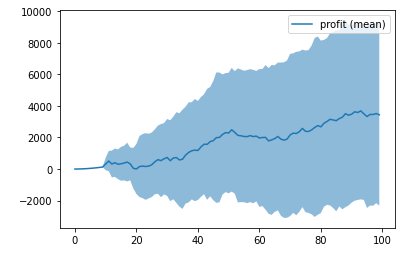

In [4]:
class MySmoothObserver(MyObserver):
    metrics = MyObserver.metrics + ["pool_loan"]

    def get_pool_loan(self, pool, **kwargs):
        return self.token.pool_loan.to_float()


observer_smooth = MySmoothObserver()

for run in range(50):
    pool = load_config(StringIO(YAML_SETUP))    
    run_simulation(
        pool, DAY, policy_distribution,
        policy_factory, policy_resolver, observer_smooth
    )

LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1

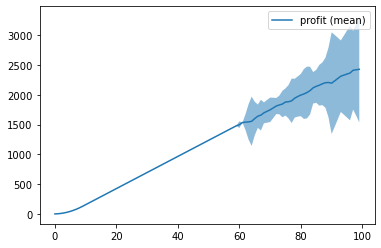

In [5]:
fig, ax = plt.subplots()
profit_mean = observer_smooth.mean("profit")
profit_std = observer_smooth.std("profit")

ax.plot(range(days), profit_mean, '-', label="profit (mean)")
ax.fill_between(range(days), profit_mean - profit_std, profit_mean + profit_std, alpha=0.5)
ax.legend()

In [6]:
observer_smooth_underestimated_loss = MySmoothObserver()

def policy_factory(pool, *args, **kwargs):
    return pool.new_policy(
        "Roulette", payout=_W(360), premium=_W(10), customer="CUST1",
        loss_prob=_R(90/3700), expiration=pool.now() + int(9.5 * DAY),
    )


for run in range(20):
    pool = load_config(StringIO(YAML_SETUP))    
    run_simulation(
        pool, DAY, policy_distribution,
        policy_factory, policy_resolver, observer_smooth_underestimated_loss
    )



LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000


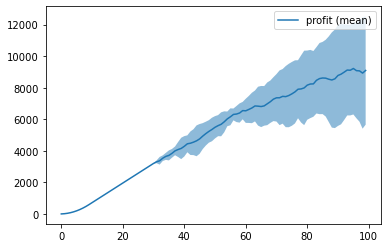

In [7]:
fig, ax = plt.subplots()
profit_mean = observer_smooth_underestimated_loss.mean("profit")
profit_std = observer_smooth_underestimated_loss.std("profit")

ax.plot(range(days), profit_mean, '-', label="profit (mean)")
ax.fill_between(range(days), profit_mean - profit_std, profit_mean + profit_std, alpha=0.5)
ax.legend()

In [8]:
observer_smooth_overestimated_loss = MySmoothObserver()

def policy_factory(pool, *args, **kwargs):
    return pool.new_policy(
        "Roulette", payout=_W(360), premium=_W(10), customer="CUST1",
        loss_prob=_R(102/3700), expiration=pool.now() + int(9.5 * DAY),
    )


for run in range(20):
    pool = load_config(StringIO(YAML_SETUP))    
    run_simulation(
        pool, DAY, policy_distribution,
        policy_factory, policy_resolver, observer_smooth_overestimated_loss
    )



LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000


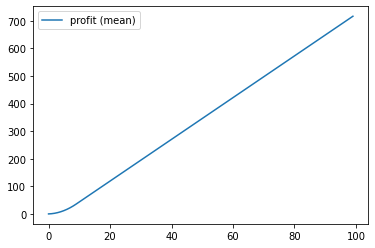

In [9]:
fig, ax = plt.subplots()
profit_mean = observer_smooth_overestimated_loss.mean("profit")
profit_std = observer_smooth_overestimated_loss.std("profit")

ax.plot(range(days), profit_mean, '-', label="profit (mean)")
ax.fill_between(range(days), profit_mean - profit_std, profit_mean + profit_std, alpha=0.5)
ax.legend()